# Stage III
## Task 1:
- ### Part 1. Develop Linear and Non-Linear (polynomial) regression models for predicting cases and deaths in US.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn
import sys
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as smfem

In [26]:
#define the utilities folder for team functions
sys.path.insert(0,"util")
import teamsuperfileutilslib as tLibs

## common defs

In [27]:
def get_totals_dataframe(dataToProcess, normilizedByPop=False, popluation=0, normilizedByPopPerMultiplier=1000000):
    """ return a new dataframe by converting the running total to actual new total. Cleans the data of any na values.
        Adds a week number to the data from the date column. Shapes the data.
    """
    #get a grad total of the days for the confirmed cases.
    daily_cols = pd.DataFrame(dataToProcess[dataToProcess.columns[4:]].sum(axis=0)).reset_index()

    #rename column to totals
    daily_cols.columns=["date","daily_count"]
    
    #Remove running total and get the acutal value for the day
    daily_cols.daily_count = daily_cols.daily_count.diff()

    #Fill any missing "na" values with 0
    daily_cols.daily_count = daily_cols.daily_count.fillna(value=0)

    #calculate new cases normalize by population
    if normilizedByPop:
        daily_cols["daily_count"] = daily_cols.apply(lambda row: round((row["daily_count"] / popluation) * normilizedByPopPerMultiplier,0), axis=1)

    #convert date column to a pandas date
    daily_cols["date"] = pd.to_datetime(daily_cols["date"])

    #insert a new column with the week number
    daily_cols["week_number"] = daily_cols["date"].dt.week

    #convet grand to int
    daily_cols["daily_count"] = daily_cols["daily_count"].apply(np.int64)

    daily_cols["days_since_infection_start"] = -1

    rIndexFirstIns = -1
    for index, row in daily_cols.iterrows():
        if row["daily_count"] > 0:
            rIndexFirstIns = index
            break
    
    daily_cols["days_since_infection_start"] = daily_cols.apply(lambda row: row.name - rIndexFirstIns if row.name >= rIndexFirstIns else -1, axis=1)
    
    return daily_cols

In [28]:
def  get_data_from_first_infection(confirmed_or_deaths_df, normilizedByPop=False, popluation=0, normilizedByPopPerMultiplier=1000000):
    #Get data for all of USA of new cases
    df_from_1ft_infec = get_totals_dataframe(confirmed_or_deaths_df, normilizedByPop, popluation, normilizedByPopPerMultiplier)

    #Get the data for starting from first infection
    df_from_1ft_infec = df_from_1ft_infec[df_from_1ft_infec.apply(lambda x: (x["days_since_infection_start"] != -1), axis=1)]
    return df_from_1ft_infec

In [29]:
def seven_day_increase_to_dataframe(infection_df):
    #Get the last day of the current confirmed cases
    last_day = infection_df['days_since_infection_start'].tail(1).iloc[0]
    
    #create list of days to perdict out by adding 7 days to the current days list
    days_to_perdict = np.array([day + last_day + 1  for day in range(7)])
    days_to_perdict = infection_df[['days_since_infection_start']].copy().append(pd.DataFrame(days_to_perdict, columns=['days_since_infection_start']),ignore_index=True)
    return days_to_perdict


In [30]:
def predict_future(modelRm, days_to_perdict_df):

    #Create new dataframe with the new predictions
    furture_precition = modelRm.predict(days_to_perdict_df)

    #Create new dataframe with future 7-days predicition
    future_precition_7_days = [round(fp,0) for fp in furture_precition[:]]
    future_precition_7_days = pd.DataFrame(future_precition_7_days, columns=['daily_count'])

    #Combine The Future precitions & the Future days into one dataframe with 2 columns
    future_precition_7_days = pd.concat([days_to_perdict_df.iloc[:].reset_index(drop=True), future_precition_7_days.reset_index(drop=True)], axis=1, ignore_index=False)
    return future_precition_7_days

In [31]:
def plot_models_currentData(infection_df, data_title, linear_model, nonlinear_model):
     plt.figure(figsize=(15,5))
    
     #Plot the current/real data as scatter plot
     plt.scatter(infection_df["days_since_infection_start"], infection_df["daily_count"], label=data_title)

     #Plot the linear_model 
     plt.plot(infection_df["days_since_infection_start"], round(linear_model.predict(infection_df["days_since_infection_start"]),0), \
         label="Linear Model", c="darkred")
     
     #Plot the nonlinear_model
     plt.plot(infection_df["days_since_infection_start"], round(nonlinear_model.predict(infection_df["days_since_infection_start"]),0), \
         label="Non-Linear Model", c="darkgreen")

     #set plot information text
     plt.xlabel("Days Since First Infection")
     plt.ylabel("Total {}".format(data_title))

     plt.legend()

     plt.title("{} & Liear Model".format(data_title))
     plt.show()

In [32]:
def plot_model_currentData_future(infection_df, data_title, modelRm, predictions):
     plt.figure(figsize=(15,5))

     #Plot the current/real data as scatter plot
     plt.scatter(infection_df["days_since_infection_start"], infection_df["daily_count"], label=data_title )
     
     #Plot the predicitions for the next 7-days
     plt.plot(predictions["days_since_infection_start"], predictions["daily_count"], label="Prediction Non-Linear Model", c="Red")

     #Plot the model for the current data
     plt.plot(infection_df["days_since_infection_start"], round(modelRm.predict(infection_df["days_since_infection_start"]),0), \
         label="Non-Linear Model", c="darkgreen")
  
     plt.xlabel("Days Since First Infection")
     plt.ylabel("Total {}".format(data_title))

     plt.legend()

     plt.title("{}, Model, & Predictions".format(data_title))
     plt.show()

In [33]:
def create_and_shape_filter_world_dataset_for_countries(world_covid_dataset, countriesToUse = [], normilizedByPop=False, normilizedByPopPerMultiplier=1000000):
    """ return a new dataframe from the world data file by the requested countries with location, date, new cases, new deaths.
    """
    #Filter out countries we don't care about
    world_countries_set = world_covid_data[world_covid_dataset.apply(lambda x: (x["location"] in countriesToUse), axis=1)]

    #Only keep the column new cases and deaths
    world_countries_set = world_countries_set[["location", "date", "new_cases", "new_deaths", "population"]]

    #convert date column to a pandas date
    world_countries_set.date = pd.to_datetime(world_countries_set.date)
    
    #insert a new column with the week number
    world_countries_set["week_number"] = world_countries_set["date"].dt.week

    #zero out empty values
    world_countries_set["new_cases"] = world_countries_set["new_cases"].fillna(value=0)

    #zero out empty values
    world_countries_set["new_deaths"] = world_countries_set["new_deaths"].fillna(value=0)

    #convet new cases to ints
    world_countries_set["new_cases"] = world_countries_set["new_cases"].apply(np.int64)

    #convet new deaths to ints
    world_countries_set["new_deaths"] = world_countries_set["new_deaths"].apply(np.int64)

    #normalize by population
    if normilizedByPop:
        world_countries_set["new_cases"] = world_countries_set.apply(lambda row: round((row["new_cases"] / row["population"]) * normilizedByPopPerMultiplier,0), axis=1)
        world_countries_set["new_deaths"] = world_countries_set.apply(lambda row: round((row["new_deaths"] / row["population"]) * normilizedByPopPerMultiplier,0), axis=1)
         
    return world_countries_set

In [34]:
def convert_world_data_to_days_and_daily_count(world_data, country, confirmed_or_death=True,normilizedByPop = False, normilizedByPopPerMultiplier = 100000000):
    #Filter out countries we don't care about
    df_contry = world_data[world_data.apply(lambda x: (x["location"] == country), axis=1)]
    
    #keep data for confirmed or deaths columns
    if confirmed_or_death:
        df_contry = df_contry[["date", "new_cases", "population"]]
        df_contry.rename(columns={"new_cases":"daily_count"}, inplace=True)
    else:
        df_contry = df_contry[["date", "new_deaths", "population"]]
        df_contry.rename(columns={"new_deaths":"daily_count"}, inplace=True)
    
    df_contry["date"] = pd.to_datetime(df_contry["date"])

    #Fill any missing "na" values with 0
    df_contry.daily_count = df_contry.daily_count.fillna(value=0)

    #convet grand to int
    df_contry["daily_count"] = df_contry["daily_count"].apply(np.int64)
    
    #calculate new cases normalize by population
    if normilizedByPop:
        df_contry["daily_count"] = df_contry.apply(lambda row: round((row["daily_count"] / row["population"]) * normilizedByPopPerMultiplier,0), axis=1)

    df_contry["days_since_infection_start"] = -1

    rIndexFirstIns = -1
    for index, row in df_contry.iterrows():
        if row["daily_count"] > 0:
            rIndexFirstIns = index
            break
    
    df_contry["days_since_infection_start"] = df_contry.apply(lambda row: row.name - rIndexFirstIns if row.name >= rIndexFirstIns else -1, axis=1)
    df_contry = df_contry[df_contry.apply(lambda x: (x["days_since_infection_start"] >= 0), axis=1)]
    #df_contry = df_contry[["days_since_infection_start","daily_count"]]
    return df_contry


In [35]:
def show_world_contry_plot_and_predicted_values(world_data, country, confirmed_or_death=True, normilizedByPop=False, normilizedByPopPerMultiplier=100000000):
    #Get the day since first infection and daily counts for Brazil
    country_data = convert_world_data_to_days_and_daily_count(world_data, country, confirmed_or_death,normilizedByPop, normilizedByPopPerMultiplier)
     
    #append the days needed to the current latest days
    country_data_days_to_perdict = seven_day_increase_to_dataframe(country_data)

    #Create the linear model from confirmed cases
    # X = days_since_infection_start & Y = daily_count
    country_data_NonLinerRM = smf.ols(formula='daily_count ~ days_since_infection_start + I(days_since_infection_start ** 2.00) + I(days_since_infection_start ** 3.00) + I(days_since_infection_start ** 4.00)', data=country_data).fit()

    #Get the prediciton for the next 7 days using the non-linear model
    country_data_future_predicition_7_days = predict_future(country_data_NonLinerRM, country_data_days_to_perdict)

    #Plot the data with the future predicitions
    plot_title = ""
    if confirmed_or_death:
        plot_title = "{} {}".format(country, "Confirmed Cases")
    else:
        plot_title = "{} {}".format(country, "Deaths")

    if normilizedByPop:
        print("**** Normalize By Population Per {:,} ****".format(normilizedByPopPerMultiplier))
        
    plot_model_currentData_future(country_data, plot_title, country_data_NonLinerRM, country_data_future_predicition_7_days)

    if normilizedByPop:
        print("**** Normalize By Population Per {:,} ****".format(normilizedByPopPerMultiplier))

    print(country_data_future_predicition_7_days.tail(7))

### Load Team Super File

In [36]:
#read team super file
team_super_df =  pd.read_csv("..\data\superCOVID-19dataframe.csv")

print(team_super_df.head())

   countyFIPS            County Name State  population  stateFIPS  \
0           0  Statewide Unallocated    AL           0          1   
1        1001         Autauga County    AL       55869          1   
2        1003         Baldwin County    AL      223234          1   
3        1005         Barbour County    AL       24686          1   
4        1007            Bibb County    AL       22394          1   

   confirmed_1/22/20  confirmed_1/23/20  confirmed_1/24/20  confirmed_1/25/20  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   confirmed_1/26/20  ...  deaths_11/10/20  deaths_11/11/20  deaths_11/12/20  \
0                 

## Calculate totals for each dataset

In [37]:
#Get confirmed cases and deaths from super team data file.
confirmed_cases, deaths = tLibs.get_confirmed_deaths_tuple_df(team_super_df)

print(confirmed_cases.head())
print(deaths.head())

   countyFIPS            County Name State  stateFIPS  1/22/20  1/23/20  \
0           0  Statewide Unallocated    AL          1        0        0   
1        1001         Autauga County    AL          1        0        0   
2        1003         Baldwin County    AL          1        0        0   
3        1005         Barbour County    AL          1        0        0   
4        1007            Bibb County    AL          1        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  11/10/20  11/11/20  11/12/20  \
0        0        0        0        0  ...         0         0         0   
1        0        0        0        0  ...      2328      2351      2385   
2        0        0        0        0  ...      7348      7409      7454   
3        0        0        0        0  ...      1107      1112      1113   
4        0        0        0        0  ...       948       961       966   

   11/13/20  11/14/20  11/15/20  11/16/20  11/17/20  11/18/20  11/19/20  
0         0       

### Process data for the confirmed cases for USA

In [38]:
#Get the popluation for the USA
usa_population_Total = team_super_df.population.sum()

#Get data for all of USA of new cases
confirm_from_1ft_infec = get_data_from_first_infection(confirmed_cases, normilizedByPop=True, popluation=usa_population_Total, normilizedByPopPerMultiplier=100000000)

print(confirm_from_1ft_infec.head(5))
print(confirm_from_1ft_infec.tail(5))

        date  daily_count  week_number  days_since_infection_start
4 2020-01-26            1            4                           0
5 2020-01-27            0            5                           1
6 2020-01-28            0            5                           2
7 2020-01-29            0            5                           3
8 2020-01-30            0            5                           4
          date  daily_count  week_number  days_since_infection_start
298 2020-11-15        40456           46                         294
299 2020-11-16        47049           47                         295
300 2020-11-17        43640           47                         296
301 2020-11-18        49469           47                         297
302 2020-11-19        58999           47                         298


### Create Linear Regresson Model from data.

In [39]:
#Create the linear model from confirmed cases
# X = days_since_infection_start & Y = daily_count
confirm_linerRM = smf.ols(formula='daily_count ~ days_since_infection_start', data=confirm_from_1ft_infec).fit()

print(confirm_linerRM.summary())
print(confirm_linerRM.params)

                            OLS Regression Results                            
Dep. Variable:            daily_count   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     516.4
Date:                Sat, 21 Nov 2020   Prob (F-statistic):           6.17e-67
Time:                        12:47:37   Log-Likelihood:                -3034.0
No. Observations:                 299   AIC:                             6072.
Df Residuals:                     297   BIC:                             6079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### Create Non-Linear (Polynomial) Regresson Model from data.

In [40]:
#Create the linear model from confirmed cases
# X = days_since_infection_start & Y = daily_count
confirm_NonLinerRM = smf.ols(formula='daily_count ~ days_since_infection_start + I(days_since_infection_start ** 2.00) + I(days_since_infection_start ** 3.00) + I(days_since_infection_start ** 4.00) + I(days_since_infection_start ** 5.00) + I(days_since_infection_start ** 6.00)', data=confirm_from_1ft_infec).fit()
print(confirm_NonLinerRM.summary())

                            OLS Regression Results                            
Dep. Variable:            daily_count   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     614.8
Date:                Sat, 21 Nov 2020   Prob (F-statistic):          5.36e-153
Time:                        12:47:37   Log-Likelihood:                -2819.6
No. Observations:                 299   AIC:                             5651.
Df Residuals:                     293   BIC:                             5673.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Plot both Linear & Non-Linear Model Normalize By Population Per 100,000,000

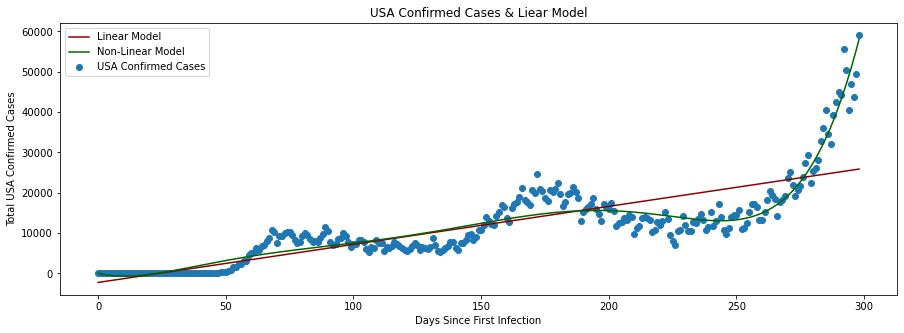

*Normalize By Population Per 100,000,000


In [41]:
#Plot current data and both models
plot_models_currentData(confirm_from_1ft_infec, "USA Confirmed Cases", confirm_linerRM, confirm_NonLinerRM)
print("*Normalize By Population Per 100,000,000")

### Validate Each Model with the RMSE

In [42]:
#Calculate the RMSE for each model
confirm_rmse_linear = smfem.rmse(x1=confirm_from_1ft_infec["daily_count"], x2=confirm_linerRM.predict(confirm_from_1ft_infec["days_since_infection_start"]))
confirm_rmse_none_linear = smfem.rmse(x1=confirm_from_1ft_infec["daily_count"], x2=confirm_NonLinerRM.predict(confirm_from_1ft_infec["days_since_infection_start"]))

print("Confirmed Cases - RMSE - Linear Model: {}\t|\tNon-Linear Model: {}".format(round(confirm_rmse_linear, 2), round(confirm_rmse_none_linear, 2)))

Confirmed Cases - RMSE - Linear Model: 6174.86	|	Non-Linear Model: 3014.46


## Seems That a Non-Linear Model is better for making predicting future Confirmed Cases as it has a lower RMSE Value

### Create a new dataframe with the 7- days in the future that will be used to make the predicitions

In [43]:
#append the days needed to the current latest days
days_to_perdict = seven_day_increase_to_dataframe(confirm_from_1ft_infec)
print(days_to_perdict)

     days_since_infection_start
0                             0
1                             1
2                             2
3                             3
4                             4
..                          ...
301                         301
302                         302
303                         303
304                         304
305                         305

[306 rows x 1 columns]


### Use the Non-Linear (polynomial) regression model to predicit the 7-days after current available data.

In [44]:
#Get the prediciton for the next 7 days using the non-linear model
future_predicition_7_days = predict_future(confirm_NonLinerRM, days_to_perdict)

print("****Number of New Confirmed Cases 7-Days in the future.*****")
print()
print(future_predicition_7_days.tail(7))

****Number of New Confirmed Cases 7-Days in the future.*****

     days_since_infection_start  daily_count
299                         299      60529.0
300                         300      63145.0
301                         301      65868.0
302                         302      68700.0
303                         303      71644.0
304                         304      74704.0
305                         305      77883.0


### Plot the precitions & the current available data for Confirmed Cases Normalize By Population Per 100,000,000

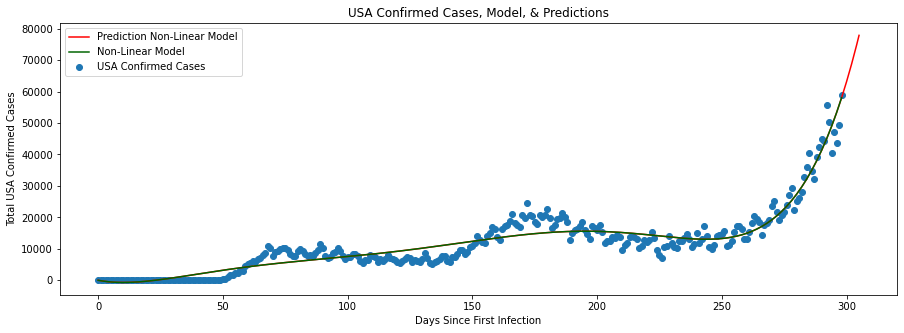

*Normalize By Population Per 100,000,000


In [45]:
#Plot the data with the future predicitions
plot_model_currentData_future(confirm_from_1ft_infec, "USA Confirmed Cases", confirm_NonLinerRM, future_predicition_7_days)
print("*Normalize By Population Per 100,000,000")

### Process data for the deaths for USA

In [46]:
#Get data for all of USA of new cases
deaths_from_1ft_infec = get_data_from_first_infection(deaths,normilizedByPop=True, popluation=usa_population_Total, normilizedByPopPerMultiplier=100000000)

print(deaths_from_1ft_infec.head(5))
print(deaths_from_1ft_infec.tail(5))

         date  daily_count  week_number  days_since_infection_start
40 2020-03-02            2           10                           0
41 2020-03-03            0           10                           1
42 2020-03-04            1           10                           2
43 2020-03-05            0           10                           3
44 2020-03-06            2           10                           4
          date  daily_count  week_number  days_since_infection_start
298 2020-11-15          182           46                         258
299 2020-11-16          219           47                         259
300 2020-11-17          433           47                         260
301 2020-11-18          576           47                         261
302 2020-11-19          685           47                         262


### Create Linear Regresson Model from data.

In [47]:
#Create the linear model from deaths cases
# X = days_since_infection_start & Y = daily_count
deaths_linerRM = smf.ols(formula='daily_count ~ days_since_infection_start', data=deaths_from_1ft_infec).fit()

print(deaths_linerRM.summary())
print(deaths_linerRM.params)

                            OLS Regression Results                            
Dep. Variable:            daily_count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8749
Date:                Sat, 21 Nov 2020   Prob (F-statistic):              0.350
Time:                        12:47:38   Log-Likelihood:                -1755.2
No. Observations:                 263   AIC:                             3514.
Df Residuals:                     261   BIC:                             3522.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### Create Non-Linear (Polynomial) Regresson Model from deaths data.

In [48]:
#Create the linear model from confirmed cases
# X = days_since_infection_start & Y = daily_count
deaths_NonLinerRM = smf.ols(formula='daily_count ~ days_since_infection_start + I(days_since_infection_start ** 2.00) + I(days_since_infection_start ** 3.00) + I(days_since_infection_start ** 4.00)', data=deaths_from_1ft_infec).fit()
print(deaths_NonLinerRM.summary())

                            OLS Regression Results                            
Dep. Variable:            daily_count   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     35.64
Date:                Sat, 21 Nov 2020   Prob (F-statistic):           1.06e-23
Time:                        12:47:38   Log-Likelihood:                -1697.8
No. Observations:                 263   AIC:                             3406.
Df Residuals:                     258   BIC:                             3424.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Plot both Linear & Non-Linear Model Normalize By Population Per 100,000,000

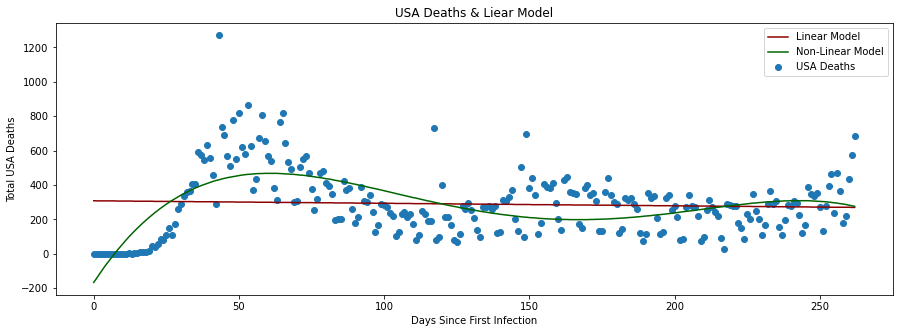

*Normalize By Population Per 100,000,000


In [49]:
#Plot current data and both models
plot_models_currentData(deaths_from_1ft_infec, "USA Deaths", deaths_linerRM, deaths_NonLinerRM)
print("*Normalize By Population Per 100,000,000")

### Validate Each Model with the RMSE

In [50]:
#Calculate the RMSE for each model
deaths_rmse_linear = smfem.rmse(x1=deaths_from_1ft_infec["daily_count"], x2=deaths_linerRM.predict(deaths_from_1ft_infec["days_since_infection_start"]))
deaths_rmse_none_linear = smfem.rmse(x1=deaths_from_1ft_infec["daily_count"], x2=deaths_NonLinerRM.predict(deaths_from_1ft_infec["days_since_infection_start"]))

In [51]:
print("Deaths - RMSE - Linear Model: {}\t|\tNon-Linear Model: {}".format(round(deaths_rmse_linear, 2), round(deaths_rmse_none_linear, 2)))

Deaths - RMSE - Linear Model: 191.52	|	Non-Linear Model: 153.97


## Seems That a Non-Linear Model is better for making predicting future Deaths as it has a lower RMSE Value

### Create a new dataframe with the 7- days in the future that will be used to make the predicitions

In [52]:
#append the days needed to the current latest days
deaths_days_to_perdict = seven_day_increase_to_dataframe(deaths_from_1ft_infec)
print(deaths_days_to_perdict)

     days_since_infection_start
0                             0
1                             1
2                             2
3                             3
4                             4
..                          ...
265                         265
266                         266
267                         267
268                         268
269                         269

[270 rows x 1 columns]


### Use the Non-Linear (polynomial) regression model to predicit the 7-days after current available data.

In [53]:
#Get the prediciton for the next 7 days using the non-linear model
deaths_future_predicition_7_days = predict_future(deaths_NonLinerRM, deaths_days_to_perdict)

print("****Number of New Deaths 7-Days in the future.*****")
print()
print(deaths_future_predicition_7_days.tail(7))

****Number of New Deaths 7-Days in the future.*****

     days_since_infection_start  daily_count
263                         263        272.0
264                         264        268.0
265                         265        264.0
266                         266        259.0
267                         267        254.0
268                         268        248.0
269                         269        243.0


### Plot the precitions & the current available data for Deaths Normalize By Population Per 100,000,000

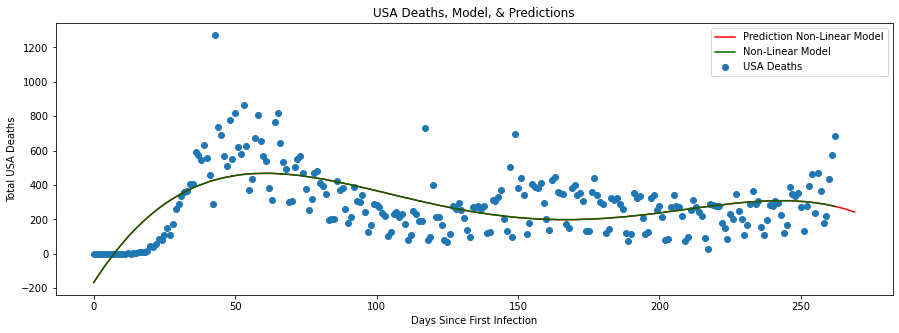

*Normalize By Population Per 100,000,000


In [54]:
#Plot the data with the future predicitions
plot_model_currentData_future(deaths_from_1ft_infec, "USA Deaths", deaths_NonLinerRM, deaths_future_predicition_7_days)
print("*Normalize By Population Per 100,000,000")

## Load World Covid Data

In [55]:
#read world csv file
world_covid_data = pd.read_csv("..\data\owid-covid-data.csv")

print(world_covid_data.shape)
print(world_covid_data.head(5))

(56325, 50)
  iso_code      continent location       date  total_cases  new_cases  \
0      ABW  North America    Aruba  3/13/2020          2.0        2.0   
1      ABW  North America    Aruba  3/19/2020          NaN        NaN   
2      ABW  North America    Aruba  3/20/2020          4.0        2.0   
3      ABW  North America    Aruba  3/21/2020          NaN        NaN   
4      ABW  North America    Aruba  3/22/2020          NaN        NaN   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         0.0                  NaN  ...   
1               0.286           NaN         NaN                  0.0  ...   
2               0.286           NaN         0.0                  0.0  ...   
3               0.286           NaN         NaN                  0.0  ...   
4               0.286           NaN         NaN                  0.0  ...   

   gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
0       35973.781        

### List of countries To Compare, Same List used in Stage II

In [56]:
#list of countries that we are going to compare
#Brazil = South America 
#Japan  = in Asia
#Mexico = North America
#Nigera = Africa
#Russia = Europe
#These countries were chosen as a way to repersent each of the world land area & similar popluations
contries_to_compare = ['Brazil', 'Japan', 'Mexico', 'Nigeria', 'Russia']

### Show Countries Data & Predictions Normalize By Population Per 100,000,000

#### Brazil Information

**** Normalize By Population Per 100,000,000 ****


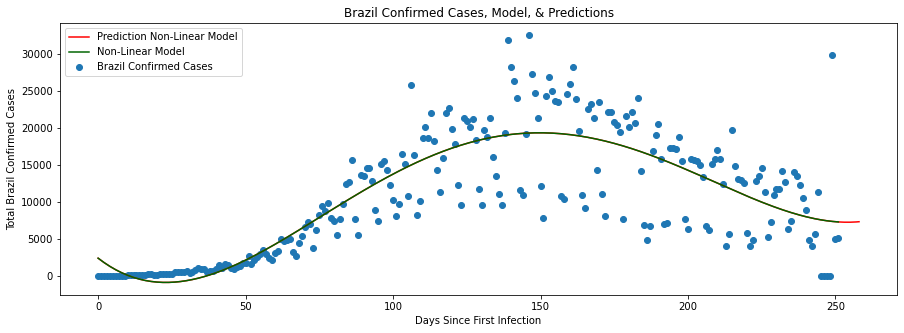

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
252                         252       7239.0
253                         253       7225.0
254                         254       7220.0
255                         255       7224.0
256                         256       7236.0
257                         257       7257.0
258                         258       7288.0


In [57]:
#Show Brazil Data & Plot, Confirmed Cases
show_world_contry_plot_and_predicted_values(world_covid_data, "Brazil", True, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

**** Normalize By Population Per 100,000,000 ****


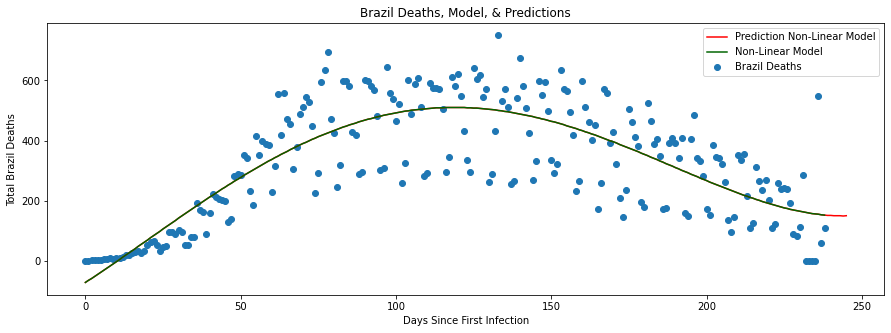

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
239                         239        151.0
240                         240        151.0
241                         241        150.0
242                         242        150.0
243                         243        150.0
244                         244        149.0
245                         245        150.0


In [58]:
#Show Brazil Data & Plot, Deaths
show_world_contry_plot_and_predicted_values(world_covid_data, "Brazil", False, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

#### Japan Information

**** Normalize By Population Per 100,000,000 ****


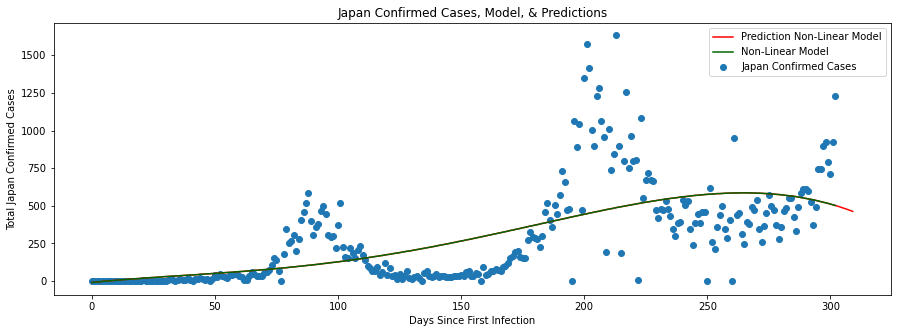

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
303                         303        497.0
304                         304        492.0
305                         305        486.0
306                         306        481.0
307                         307        475.0
308                         308        469.0
309                         309        463.0


In [59]:
#Show Japan Data & Plot, Confirmed Cases
show_world_contry_plot_and_predicted_values(world_covid_data, "Japan", True, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

**** Normalize By Population Per 100,000,000 ****


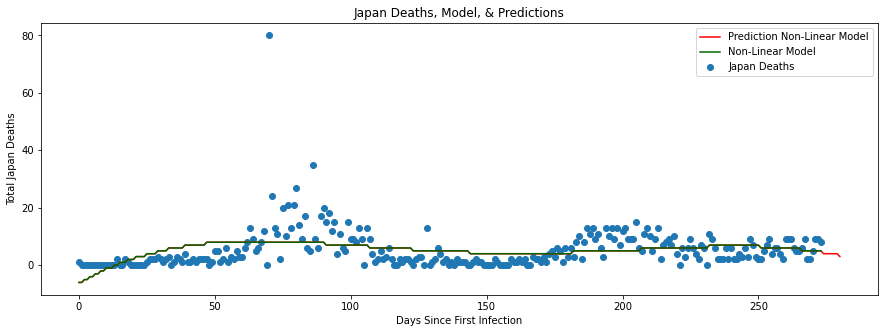

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
274                         274          4.0
275                         275          4.0
276                         276          4.0
277                         277          4.0
278                         278          4.0
279                         279          4.0
280                         280          3.0


In [60]:
#Show Japan Data & Plot, Deaths
show_world_contry_plot_and_predicted_values(world_covid_data, "Japan", False, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

#### Mexico Information

**** Normalize By Population Per 100,000,000 ****


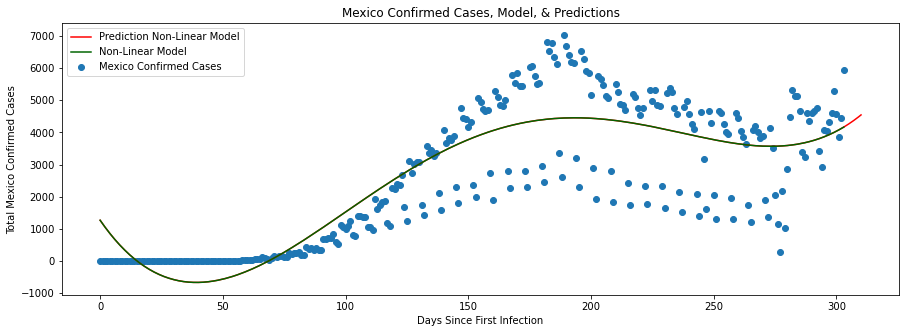

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
304                         304       4213.0
305                         305       4263.0
306                         306       4314.0
307                         307       4368.0
308                         308       4424.0
309                         309       4482.0
310                         310       4543.0


In [61]:
#Show Mexico Data & Plot, Confirmed Cases
show_world_contry_plot_and_predicted_values(world_covid_data, "Mexico", True, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

**** Normalize By Population Per 100,000,000 ****


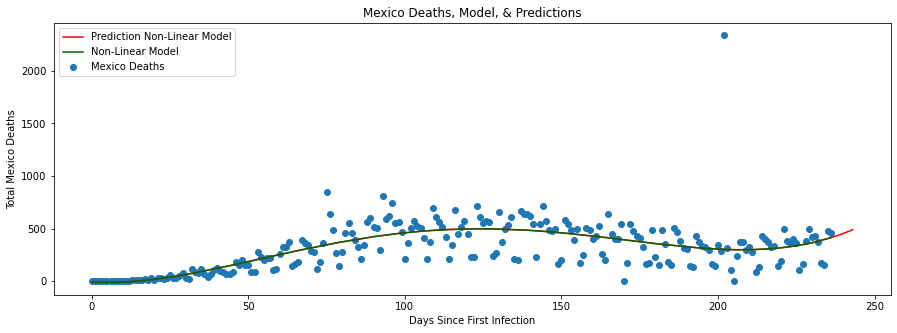

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
237                         237        422.0
238                         238        432.0
239                         239        442.0
240                         240        453.0
241                         241        465.0
242                         242        476.0
243                         243        489.0


In [62]:
#Show Mexico Data & Plot, Deaths
show_world_contry_plot_and_predicted_values(world_covid_data, "Mexico", False, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

#### Nigeria Information

**** Normalize By Population Per 100,000,000 ****


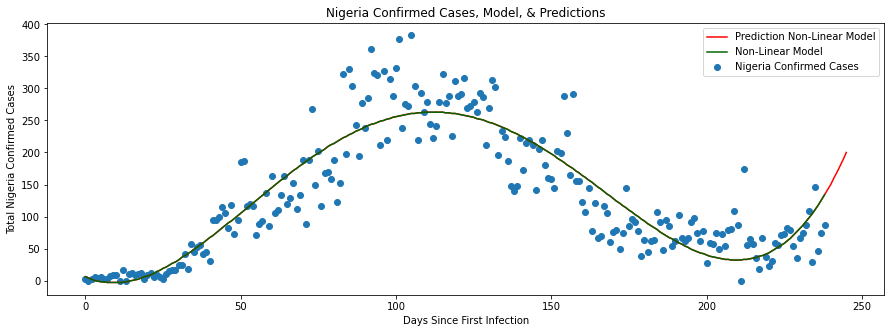

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
239                         239        142.0
240                         240        150.0
241                         241        160.0
242                         242        169.0
243                         243        179.0
244                         244        189.0
245                         245        200.0


In [63]:
#Show Nigeria Data & Plot, Confirmed Cases
show_world_contry_plot_and_predicted_values(world_covid_data, "Nigeria", True, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

**** Normalize By Population Per 100,000,000 ****


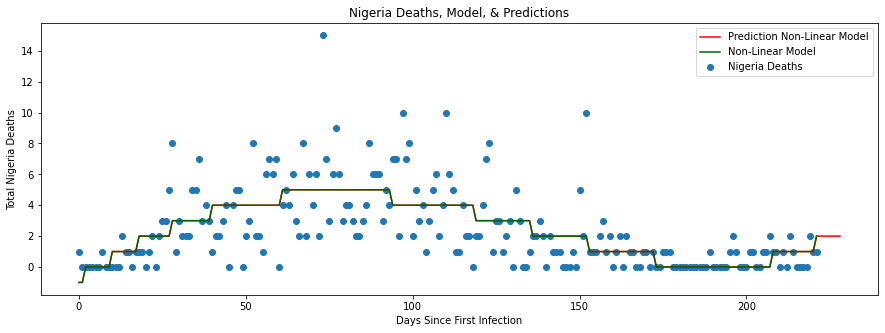

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
222                         222          2.0
223                         223          2.0
224                         224          2.0
225                         225          2.0
226                         226          2.0
227                         227          2.0
228                         228          2.0


In [64]:
#Show Nigeria Data & Plot, Deaths
show_world_contry_plot_and_predicted_values(world_covid_data, "Nigeria", False, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

#### Russia Information

**** Normalize By Population Per 100,000,000 ****


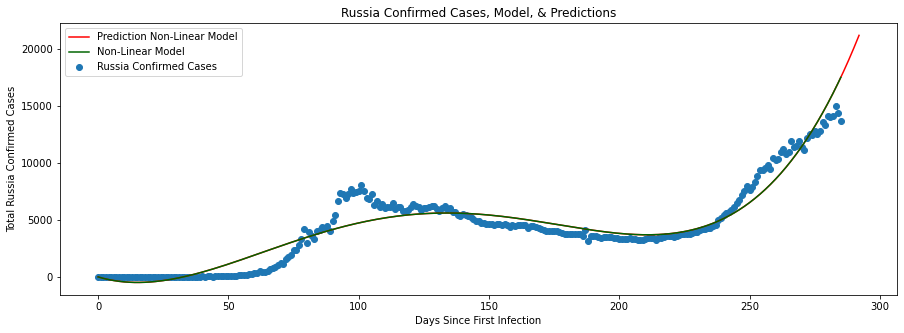

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
286                         286      17958.0
287                         287      18460.0
288                         288      18974.0
289                         289      19501.0
290                         290      20039.0
291                         291      20590.0
292                         292      21153.0


In [65]:
#Show Russia Data & Plot, Confirmed Cases
show_world_contry_plot_and_predicted_values(world_covid_data, "Russia", True, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

**** Normalize By Population Per 100,000,000 ****


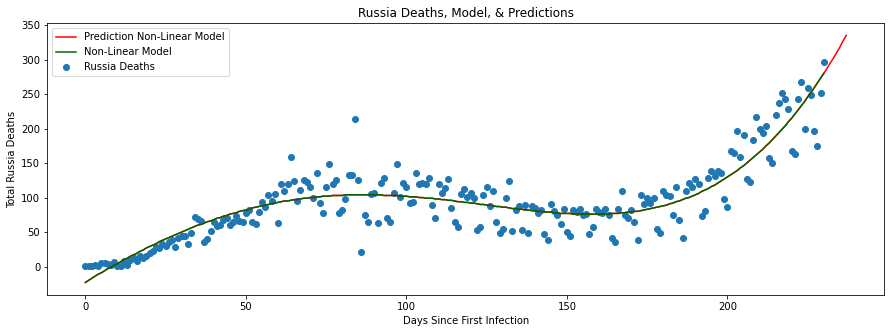

**** Normalize By Population Per 100,000,000 ****
     days_since_infection_start  daily_count
231                         231        287.0
232                         232        295.0
233                         233        302.0
234                         234        310.0
235                         235        318.0
236                         236        327.0
237                         237        335.0


In [66]:
#Show Russia Data & Plot, Deaths
show_world_contry_plot_and_predicted_values(world_covid_data, "Russia", False, normilizedByPop=True, normilizedByPopPerMultiplier=100000000)

# Trends Compared USA to Other Countries

## USA 
* ### Confirmed Cases: 
The USA is predicted to see a sharpe increase in the number of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
The USA is predicted to see a slight decrease in the number of deaths in the week of 11-13-2020 to 11-20-2020.

## Brazil  
* ### Confirmed Cases: 
Brazil is predicted to see very little change, holding at around 7200 per 100,000,000 population, of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Brazil is predicted to see very little change, holding at around 150 per 100,000,000 population, of new deaths in the week of 11-13-2020 to 11-20-2020.

## Japan   
* ### Confirmed Cases: 
Japan is predicted to see very little change, holding at around 300 per 100,000,000 population, of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Japan is predicted to see very little change, hold at around 4 per 100,000,000 population, of new deaths in the week of 11-13-2020 to 11-20-2020.

## Mexico   
* ### Confirmed Cases: 
Mexico is predicted to see a slight increase of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Mexico is predicted to see a slight increase of new deaths in the week of 11-13-2020 to 11-20-2020.

## Nigeria   
* ### Confirmed Cases: 
Nigeria is predicted to see an increase of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Nigeria is predicted to see no change, hold at around 2 per 100,000,000 population, in new deaths in the week of 11-13-2020 to 11-20-2020.

## Russia   
* ### Confirmed Cases: 
Russia is predicted to see a sharpe increase of new Confirmed cases in the week of 11-13-2020 to 11-20-2020.
* ### Deaths:
Russia is predicted to see an increase in new deaths in the week of 11-13-2020 to 11-20-2020.